In [1]:
BATCH_SIZE = 10
EPOCHS = 15
LEARNING_RATE = 0.1
SEED = 42

In [2]:
import torch
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('../datasets/mc_dev_data.txt')
test_labels, test_data = read_data('../datasets/mc_test_data.txt')

In [4]:
import os

TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

In [5]:
train_data[:5]

['skillful man prepares sauce .',
 'skillful man bakes dinner .',
 'woman cooks tasty meal .',
 'man prepares meal .',
 'skillful woman debugs program .']

In [6]:
train_labels[:5]

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0]]

In [7]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

D:\UCSD Health Volunteer\Code\quantum-computing\.venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [8]:
from lambeq import RemoveCupsRewriter

remove_cups = RemoveCupsRewriter()

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

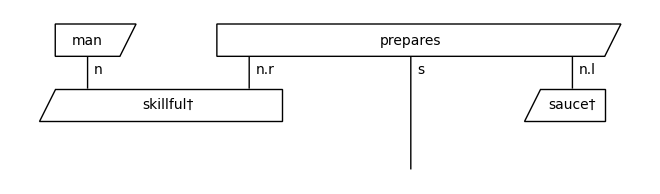

In [9]:
train_diagrams[0].draw()

In [10]:
print(train_data[0])

skillful man prepares sauce .


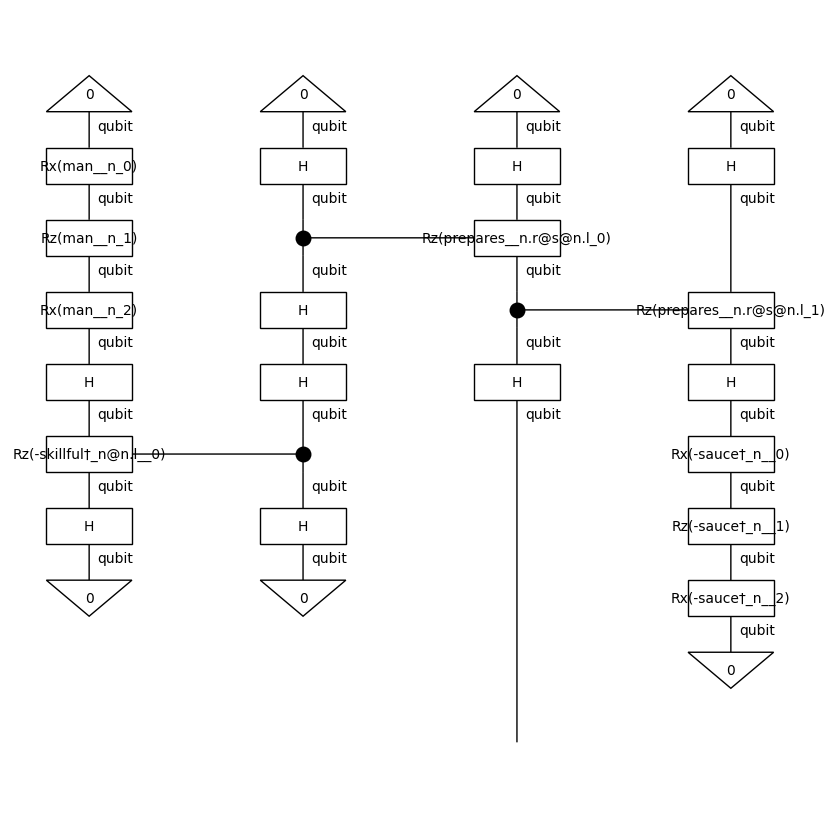

In [11]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(8, 8))

In [12]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + dev_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

In [13]:
# import pennylane as qml

# qml.default_config['qiskit.ibmq.ibmqx_token'] = 'my_API_token'
# qml.default_config.save(qml.default_config.path)
# backend_config = {'backend': 'qiskit.ibmq',
#                   'device': 'ibmq_manila',
#                   'shots': 1000}

In [14]:
# if TESTING:
#     backend_config = None

In [15]:
# q_model = PennyLaneModel.from_diagrams(all_circuits,
#                                        probabilities=True,
#                                        normalize=True,
#                                        backend_config=backend_config)
# q_model.initialise_weights()

In [16]:
# qml.default_config['honeywell.global.user_email'] = ('my_Honeywell/Quantinuum_'
#                                                      'account_email')
# qml.default_config.save(qml.default_config.path)

# backend_config = {'backend': 'honeywell.hqs',
#                   'device': 'H1-1E',
#                   'shots': 1000}

In [17]:
# if TESTING:
#     backend_config = None

In [18]:
# h_model = PennyLaneModel.from_diagrams(all_circuits,
#                                        probabilities=True,
#                                        normalize=True,
#                                        backend_config=backend_config)
# h_model.initialise_weights()

In [19]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels)

In [20]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

In [21]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

In [22]:
trainer.fit(train_dataset, val_dataset)

Epoch 1:   train/loss: 0.1207   valid/loss: 0.0919   train/time: 1.38s   valid/time: 0.43s   train/acc: 0.7857   valid/acc: 0.8667
Epoch 2:   train/loss: 0.0486   valid/loss: 0.1035   train/time: 1.27s   valid/time: 0.44s   train/acc: 0.9286   valid/acc: 0.9000
Epoch 3:   train/loss: 0.0364   valid/loss: 0.0621   train/time: 1.46s   valid/time: 0.44s   train/acc: 0.9429   valid/acc: 0.9333
Epoch 4:   train/loss: 0.0466   valid/loss: 0.0392   train/time: 1.27s   valid/time: 0.44s   train/acc: 0.9857   valid/acc: 1.0000
Epoch 5:   train/loss: 0.0120   valid/loss: 0.0126   train/time: 1.30s   valid/time: 0.44s   train/acc: 0.9857   valid/acc: 1.0000
Epoch 6:   train/loss: 0.0014   valid/loss: 0.0178   train/time: 1.46s   valid/time: 0.44s   train/acc: 1.0000   valid/acc: 1.0000
Epoch 7:   train/loss: 0.0022   valid/loss: 0.0079   train/time: 1.31s   valid/time: 0.46s   train/acc: 1.0000   valid/acc: 1.0000
Epoch 8:   train/loss: 0.0041   valid/loss: 0.0061   train/time: 1.30s   valid/time

Final test accuracy: 0.9666666666666667


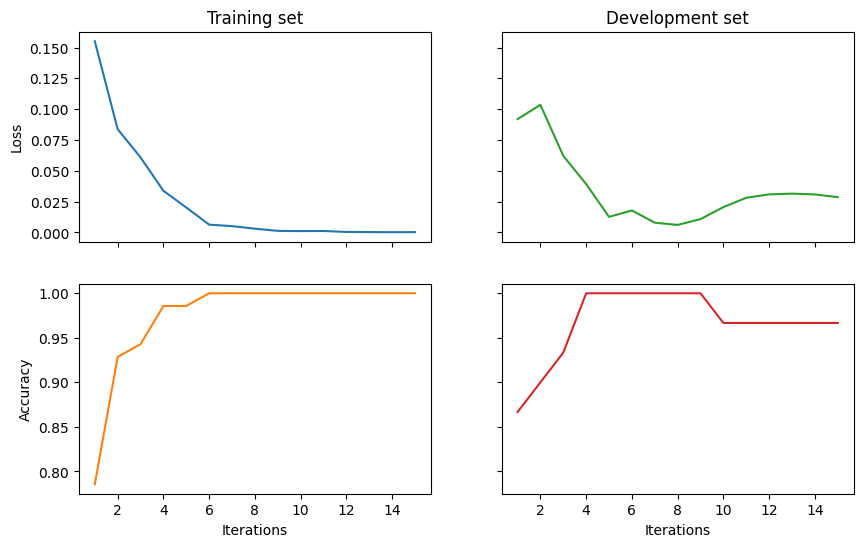

In [23]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

In [24]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) ==
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

In [25]:
model = PennyLaneModel.from_diagrams(all_circuits)
model.initialise_weights()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_dataset:
        optimizer.zero_grad()
        probs = model(circuits)
        loss = torch.nn.functional.mse_loss(probs,
                                            torch.tensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    if i % 5 == 0:
        dev_acc = accuracy(dev_circuits, dev_labels)

        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))

        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save('model.lt')
        elif i - best['epoch'] >= 10:
            print('Early stopping')
            break

if best['acc'] > accuracy(dev_circuits, dev_labels):
    model.load('model.lt')

Epoch: 0
Train loss: 1.8359990119934082
Dev acc: 0.5333333333333333
Epoch: 5
Train loss: 0.19101136410608888
Dev acc: 0.9
Epoch: 10
Train loss: 0.059297572006471455
Dev acc: 0.9666666666666667


In [26]:
print('Final test accuracy: {}'.format(accuracy(test_circuits, test_labels)))

Final test accuracy: 1.0


In [27]:
BATCH_SIZE = 50
EPOCHS = 100
LEARNING_RATE = 0.1
SEED = 2

In [28]:
from torch import nn

class XORSentenceModel(PennyLaneModel):
    def __init__(self, **kwargs):
        PennyLaneModel.__init__(self, **kwargs)

        self.xor_net = nn.Sequential(nn.Linear(4, 10),
                                     nn.ReLU(),
                                     nn.Linear(10, 1),
                                     nn.Sigmoid())

    def forward(self, diagram_pairs):
        first_d, second_d = zip(*diagram_pairs)
        evaluated_pairs = torch.cat((self.get_diagram_output(first_d),
                                     self.get_diagram_output(second_d)),
                                    dim=1)
        evaluated_pairs = 2 * (evaluated_pairs - 0.5)
        return self.xor_net(evaluated_pairs)


In [29]:
from itertools import combinations

def make_pair_data(diagrams, labels):
    pair_diags = list(combinations(diagrams, 2))
    pair_labels = [int(x[0] == y[0]) for x, y in combinations(labels, 2)]
    return pair_diags, pair_labels

train_pair_circuits, train_pair_labels = make_pair_data(train_circuits,
                                                        train_labels)
dev_pair_circuits, dev_pair_labels = make_pair_data(dev_circuits,
                                                    dev_labels)
test_pair_circuits, test_pair_labels = make_pair_data(test_circuits,
                                                      test_labels)

In [30]:
TRAIN_SAMPLES, DEV_SAMPLES, TEST_SAMPLES = 300, 200, 200

In [31]:
if TESTING:
    TRAIN_SAMPLES, DEV_SAMPLES, TEST_SAMPLES = 1, 1, 1

In [32]:
train_pair_circuits, train_pair_labels = (
    zip(*random.sample(list(zip(train_pair_circuits, train_pair_labels)), 
                       TRAIN_SAMPLES)))
dev_pair_circuits, dev_pair_labels = (
    zip(*random.sample(list(zip(dev_pair_circuits, dev_pair_labels)), DEV_SAMPLES)))
test_pair_circuits, test_pair_labels = (
    zip(*random.sample(list(zip(test_pair_circuits, test_pair_labels)), TEST_SAMPLES)))

In [33]:
all_pair_circuits = (train_pair_circuits +
                     dev_pair_circuits +
                     test_pair_circuits)
a, b = zip(*all_pair_circuits)

model = XORSentenceModel.from_diagrams(a + b)
model.initialise_weights()
model = model

train_pair_dataset = Dataset(train_pair_circuits,
                             train_pair_labels,
                             batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [34]:
def accuracy(circs, labels):
    predicted = model(circs)
    return (torch.round(torch.flatten(predicted)) ==
            torch.Tensor(labels)).sum().item()/len(circs)

In [35]:
best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_pair_dataset:
        optimizer.zero_grad()
        predicted = model(circuits)
        loss = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.Tensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

    if i % 5 == 0:
        dev_acc = accuracy(dev_pair_circuits, dev_pair_labels)

        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))

        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.save('xor_model.lt')
        elif i - best['epoch'] >= 10:
            print('Early stopping')
            break

if best['acc'] > accuracy(dev_pair_circuits, dev_pair_labels):
    model.load('xor_model.lt')
    model = model

Epoch: 0
Train loss: 4.2918784618377686
Dev acc: 0.53
Epoch: 5
Train loss: 2.853130489587784
Dev acc: 0.865
Epoch: 10
Train loss: 0.9539860412478447
Dev acc: 0.87
Epoch: 15
Train loss: 0.12945084646344185
Dev acc: 0.95
Epoch: 20
Train loss: 0.05715207476168871
Dev acc: 0.93
Epoch: 25
Train loss: 0.03689684718847275
Dev acc: 0.93
Early stopping


In [36]:
print('Final test accuracy: {}'.format(accuracy(test_pair_circuits,
                                                test_pair_labels)))

Final test accuracy: 0.985


In [37]:
xor_labels = [[1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0]]
# the first two entries correspond to the same label for both sentences, the last two to different labels
xor_tensors = torch.tensor(xor_labels).float()

model.xor_net(xor_tensors).detach().numpy()

array([[0.9779154 ],
       [0.9748309 ],
       [0.01686393],
       [0.06134675]], dtype=float32)

In [38]:
FOOD_IDX, IT_IDX = 0, 6
symbol_weight_map = dict(zip(model.symbols, model.weights))

In [39]:
if TESTING: 
    FOOD_IDX, IT_IDX = 0, 0

In [40]:
print(test_data[FOOD_IDX])

p_circ = test_circuits[FOOD_IDX].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(symbol_weight_map)
unnorm = p_circ.eval().detach().numpy()

unnorm / np.sum(unnorm)

woman prepares tasty dinner .


array([0.523237, 0.476763], dtype=float32)

In [41]:
print(test_data[IT_IDX])

p_circ = test_circuits[IT_IDX].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(symbol_weight_map)
unnorm = p_circ.eval().detach().numpy()

unnorm / np.sum(unnorm)

skillful person runs software .


array([0.99618876, 0.00381121], dtype=float32)